In [8]:
# Install scipy and numpy
%pip install scipy numpy pandas matplotlib termcolor tabulate

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import necessary libraries
from scipy import stats
import pandas as pd

In [2]:
def read_file(file: str):
    df = pd.read_csv(file)
    # Process data into dataframe, where each row is a trial.
    # Column 1 is ticks, column 2 is used memory. Parse from existing data into values

    # Take first column and get the values
    ticks = df.iloc[:, 0].values
    ticks = [int(x.split()[-1]) for x in ticks]

    # Take second column and get the values
    memory = df.iloc[:, 1].values
    memory = [int(x.split()[-1]) for x in memory]

    return pd.DataFrame(list(zip(ticks, memory)), columns=["Ticks", "Memory (KiB)"])

In [3]:
releases = ["Ubuntu-24.04", "Ubuntu-22.04", "Ubuntu-20.04"]
cleanupType = ["shutdown", "terminate"]

files = []
for release in releases:
    for cloudinit in [True, False]:
        for hasConfig in [True, False]:
            for operation in cleanupType:
                files.append(f"./non-first-boot/{release}/{operation}-cloud-init-{cloudinit}-has-config-{hasConfig}.txt")


data = {file: read_file(file) for file in files}

In [4]:
for file in files:
    # Checking if normally distributed. (p-value > 0.05)
    print(f"File: {file}")
    print(data[file].keys())
    print(f"Ticks: {stats.shapiro(data[file]['Ticks'])}")
    print(f"Memory: {stats.shapiro(data[file]['Memory (KiB)'])}")

File: ./non-first-boot/Ubuntu-24.04/shutdown-cloud-init-True-has-config-True.txt
Index(['Ticks', 'Memory (KiB)'], dtype='object')
Ticks: ShapiroResult(statistic=np.float64(0.6303516066934185), pvalue=np.float64(1.1085113705506104e-08))
Memory: ShapiroResult(statistic=np.float64(0.9786190616785533), pvalue=np.float64(0.6533702658622246))
File: ./non-first-boot/Ubuntu-24.04/terminate-cloud-init-True-has-config-True.txt
Index(['Ticks', 'Memory (KiB)'], dtype='object')
Ticks: ShapiroResult(statistic=np.float64(0.7467847591471699), pvalue=np.float64(7.963654154767249e-07))
Memory: ShapiroResult(statistic=np.float64(0.9912477822276956), pvalue=np.float64(0.9884334735350945))
File: ./non-first-boot/Ubuntu-24.04/shutdown-cloud-init-True-has-config-False.txt
Index(['Ticks', 'Memory (KiB)'], dtype='object')
Ticks: ShapiroResult(statistic=np.float64(0.628670011779461), pvalue=np.float64(1.0491826573502892e-08))
Memory: ShapiroResult(statistic=np.float64(0.9578337326607675), pvalue=np.float64(0.15

Seems not to be normally distributed data. Can't make assumptions.
Data is collected from the same system under controlled circumstances, and can be assumed to be paired.


In [5]:
from tabulate import tabulate
from termcolor import colored

# Define the base version for comparison
base_version = "24.04"

# Prepare a list to store results for tabular display
results = []
for c in [True, False]:
    for d in [True, False]:
        for cleanup in cleanupType:
            base_file = f"./non-first-boot/Ubuntu-{base_version}/{cleanup}-cloud-init-{c}-has-config-{d}.txt"
            for version in releases:
                if version.split("-")[-1] == base_version:
                    continue  # Skip comparison with the base version itself
                compare_file = (
                    f"./non-first-boot/{version}/{cleanup}-cloud-init-{c}-has-config-{d}.txt"
                )
                if base_file in data and compare_file in data:
                    ticks_result = stats.wilcoxon(
                        data[base_file]["Ticks"], data[compare_file]["Ticks"]
                    )
                    memory_result = stats.wilcoxon(
                        data[base_file]["Memory (KiB)"],
                        data[compare_file]["Memory (KiB)"],
                    )
                    results.append(
                        [
                            colored(base_file.split("/")[-2:], "cyan"),
                            colored(compare_file.split("/")[-2:], "cyan"),
                            colored(
                                f"Ticks: {ticks_result}",
                                "green" if ticks_result.pvalue > 0.05 else "red",
                            ),
                            colored(
                                f"Memory: {memory_result}",
                                "green" if memory_result.pvalue > 0.05 else "red",
                            ),
                        ]
                    )
                else:
                    results.append(
                        [
                            colored(base_file.split("/")[-1], "cyan"),
                            colored(compare_file.split("/")[-1], "cyan"),
                            colored("Data missing", "yellow"),
                            colored("Data missing", "yellow"),
                        ]
                    )

# Print the results in a tabular format
headers = ["Base File", "Compare File", "Ticks Result", "Memory Result"]
print(tabulate(results, headers=headers, tablefmt="grid"))

+---------------------------------------------------------------------+---------------------------------------------------------------------+-----------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------+
| Base File                                                           | Compare File                                                        | Ticks Result                                                                                  | Memory Result                                                                               |
+=====================================================================+=====================================================================+===============================================================================================+=============================================================================================+
| ['

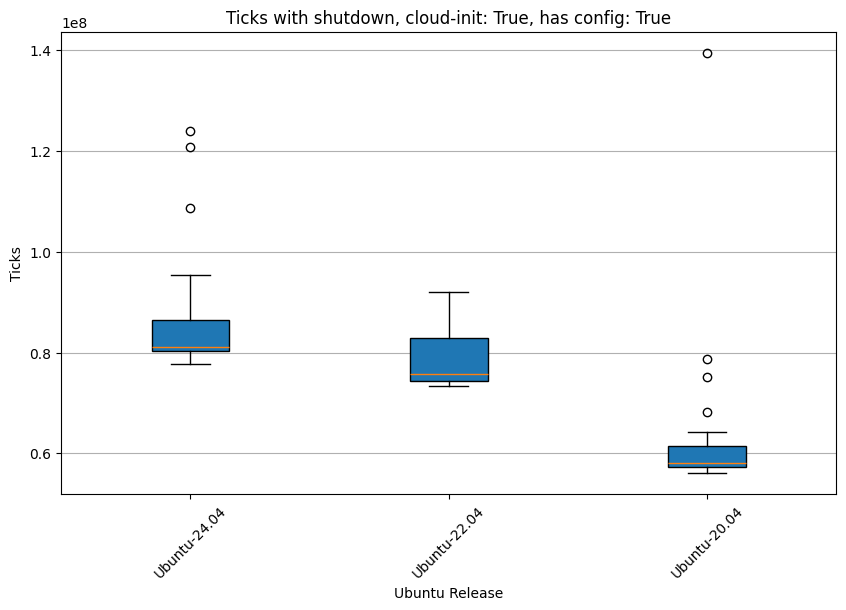

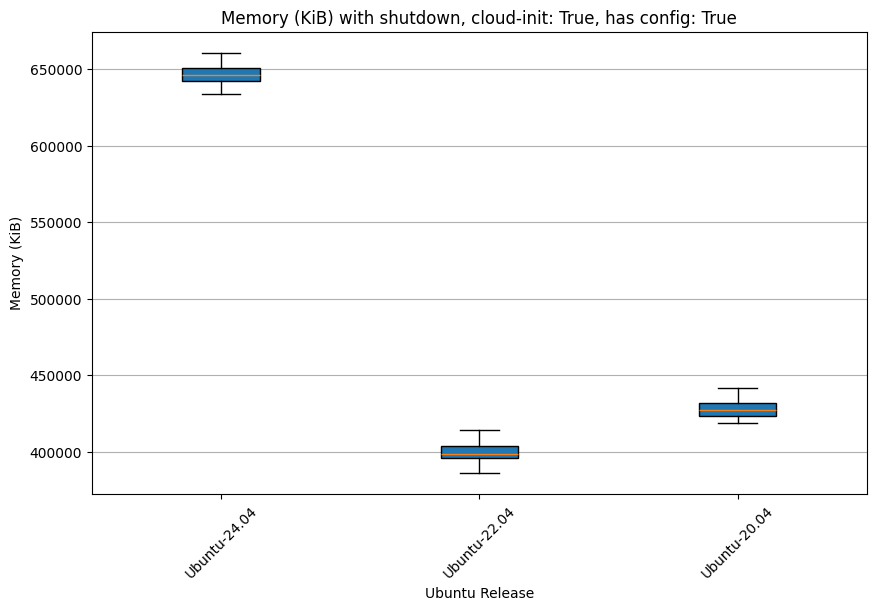

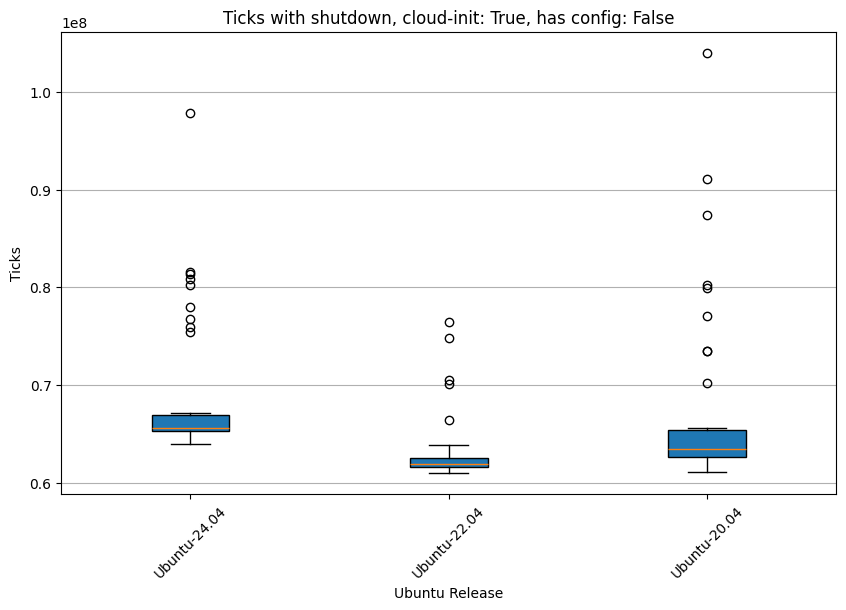

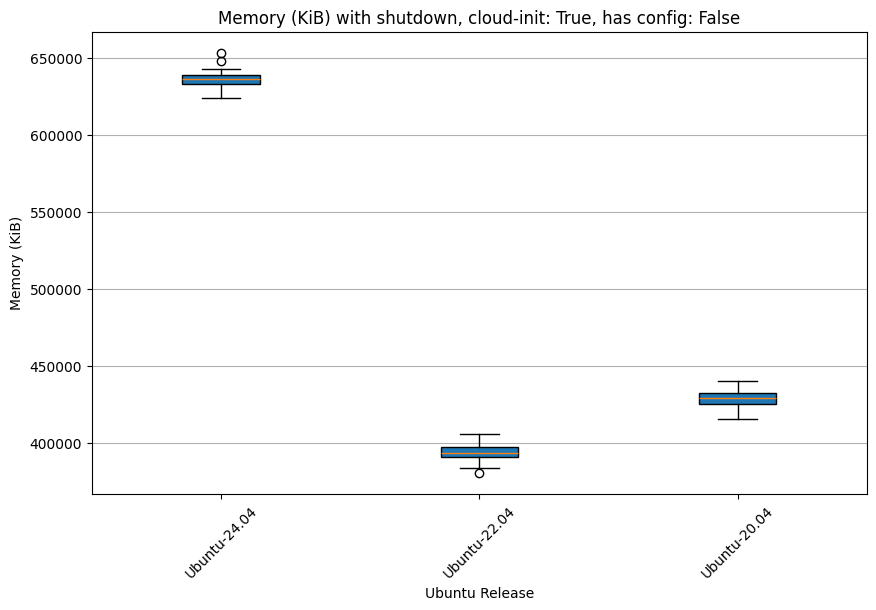

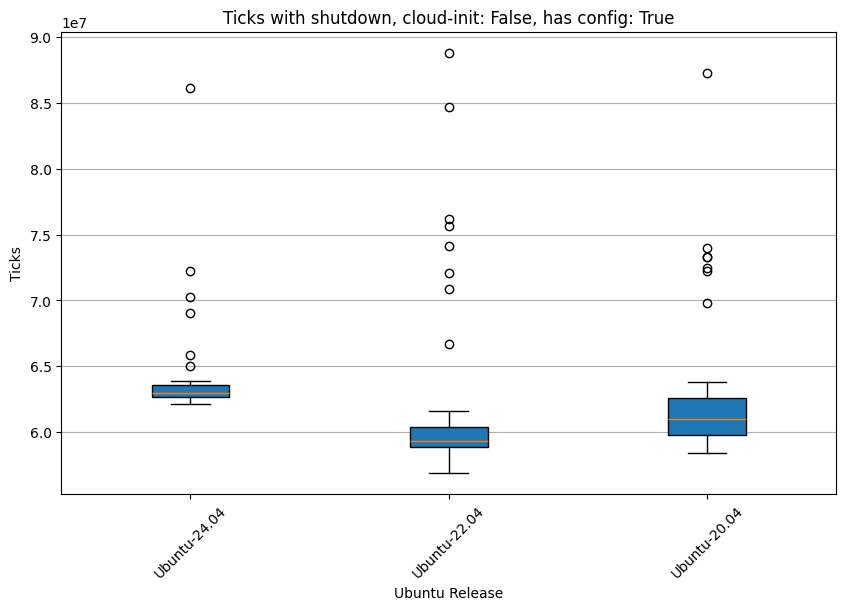

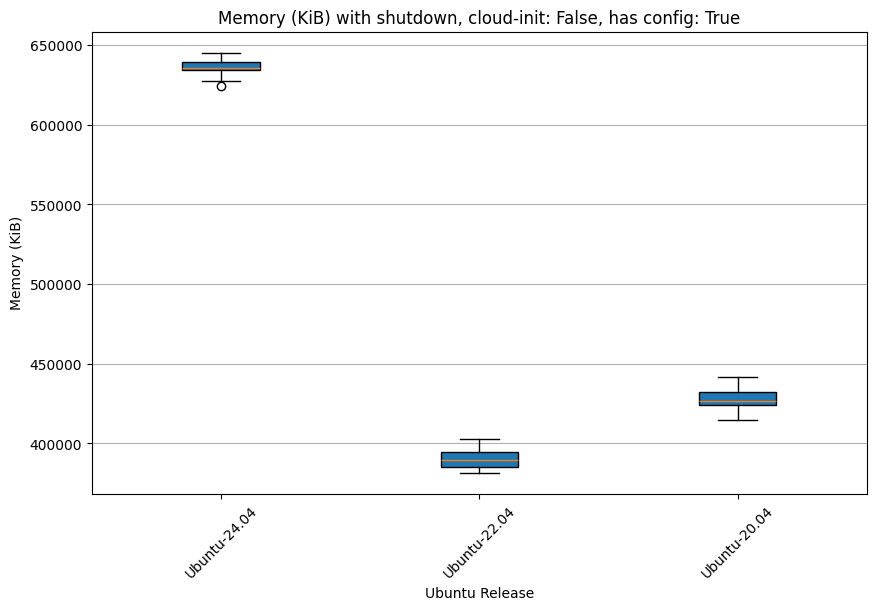

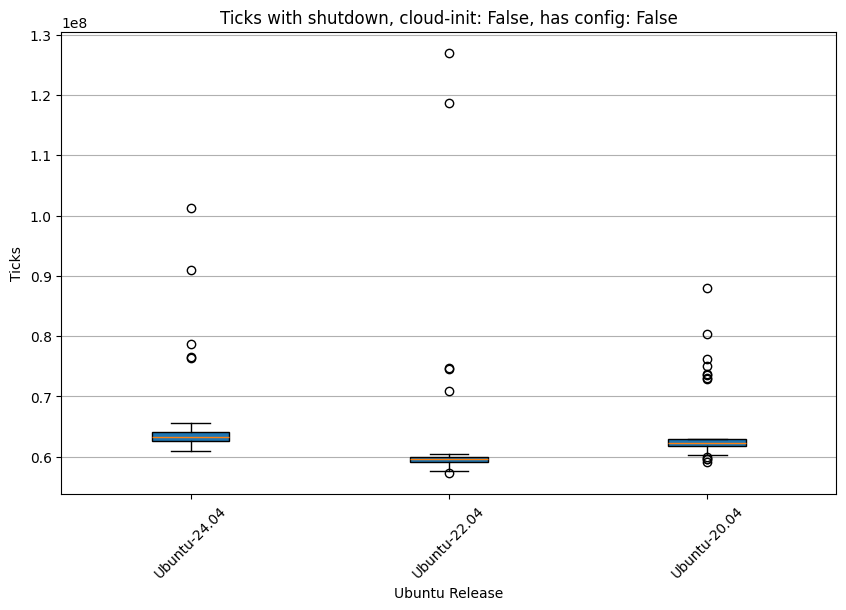

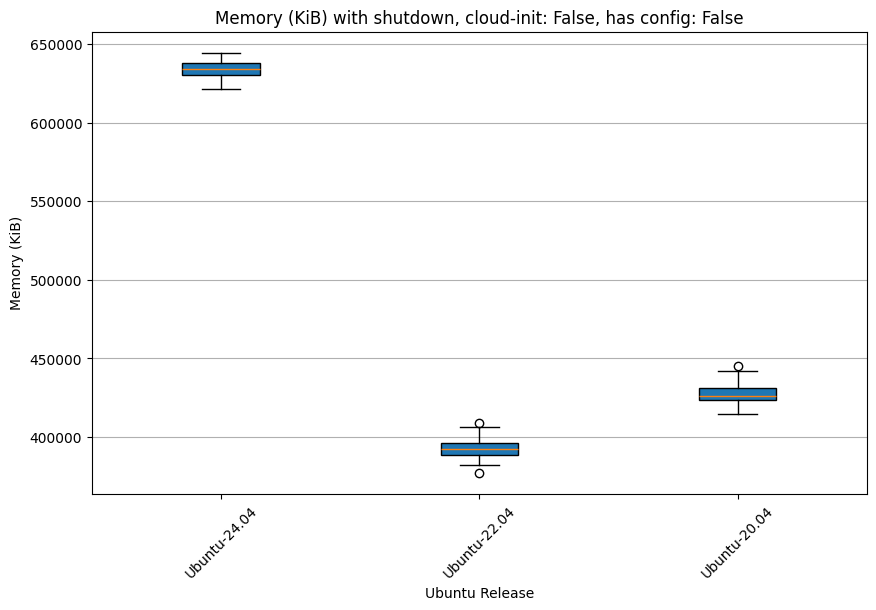

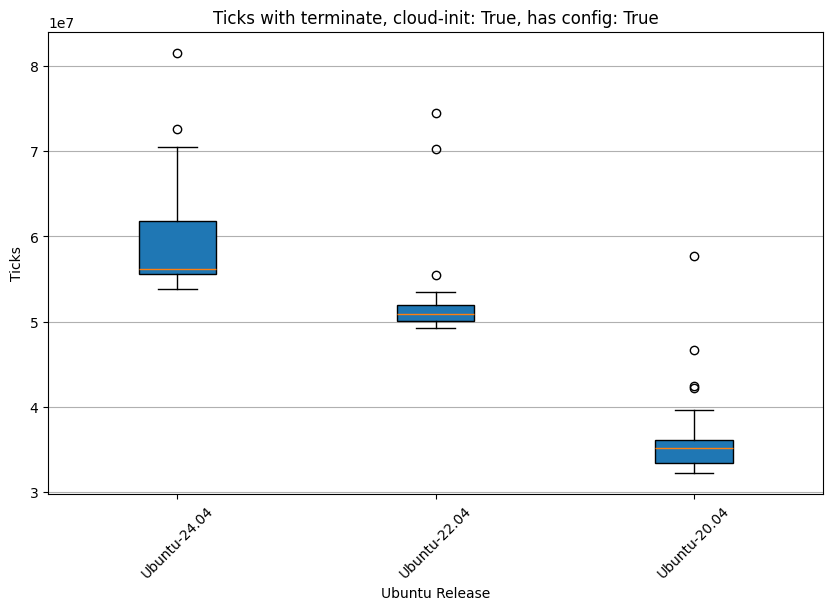

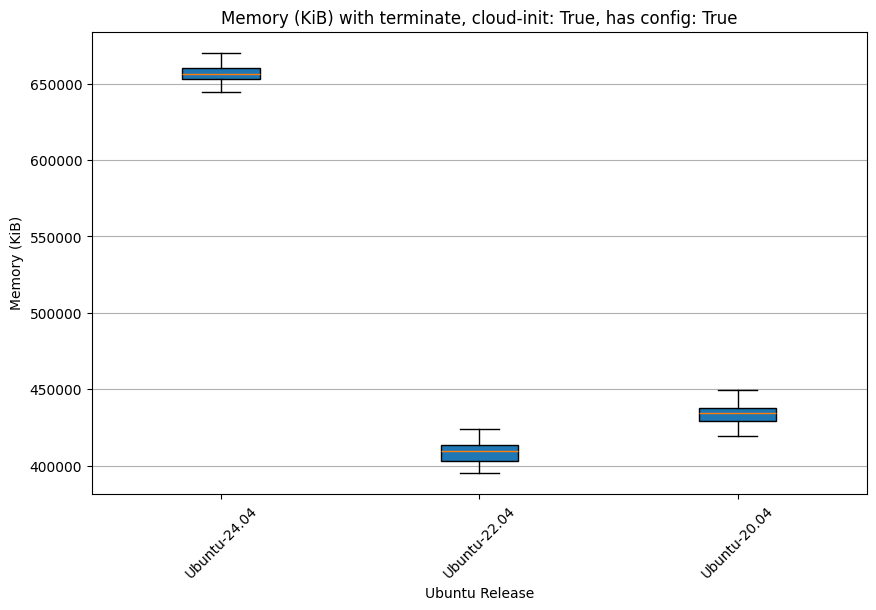

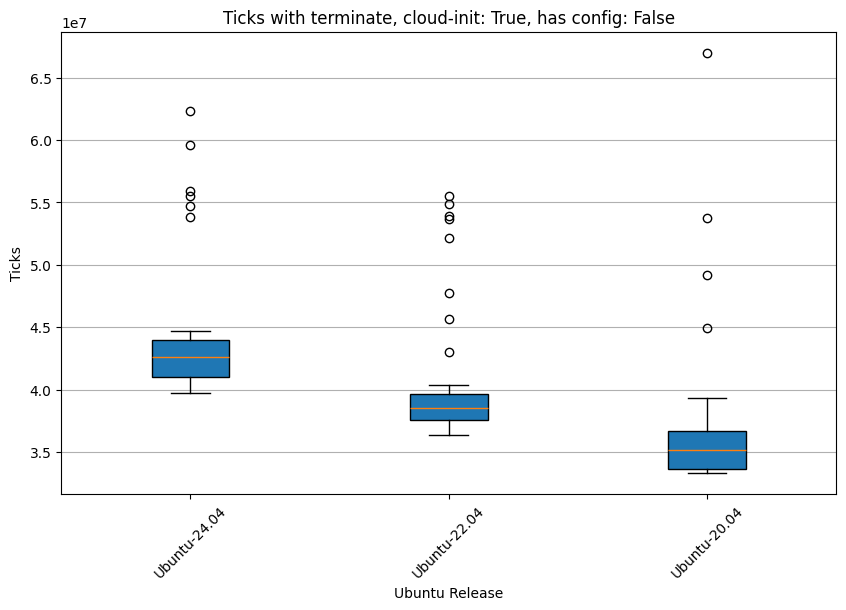

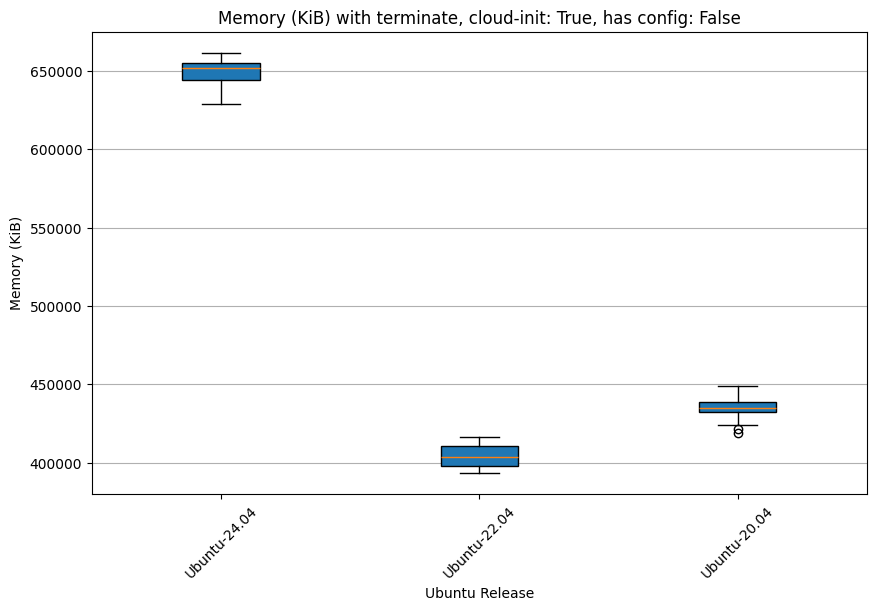

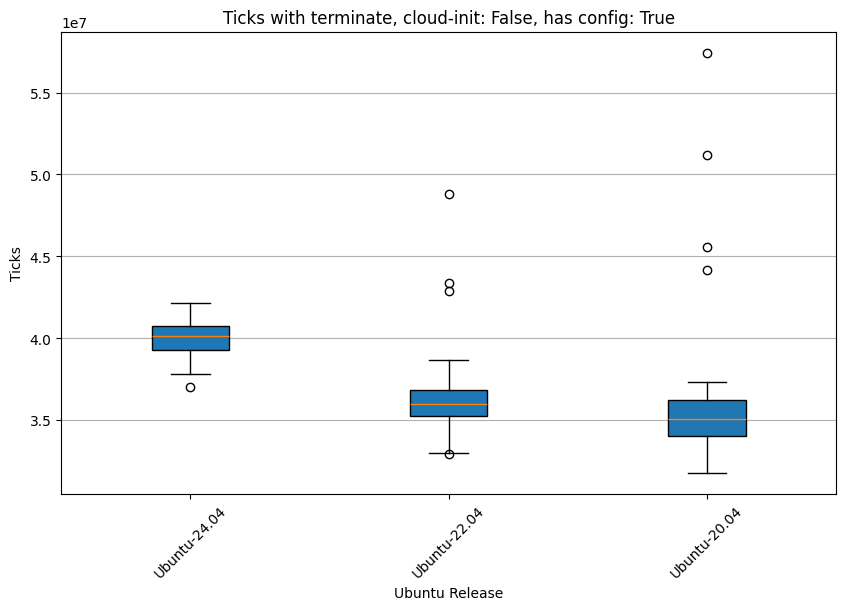

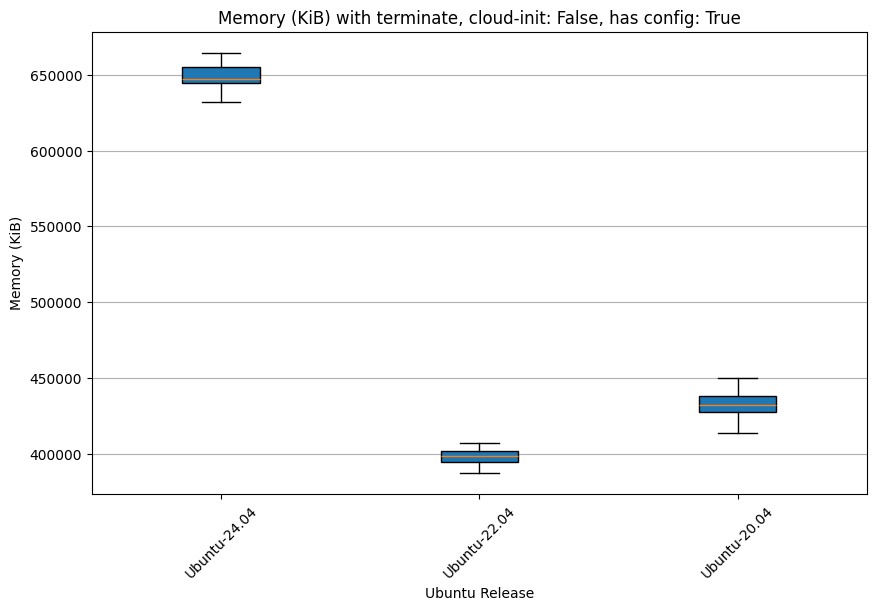

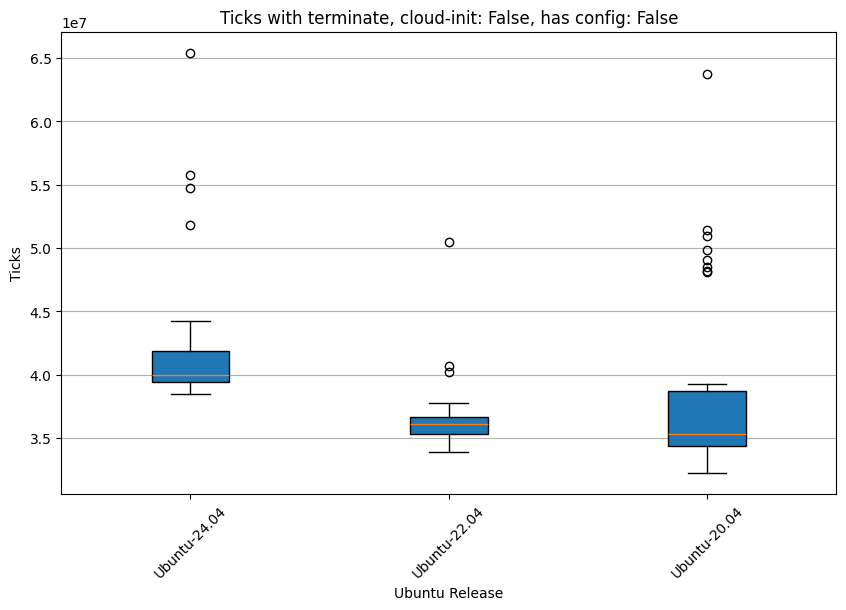

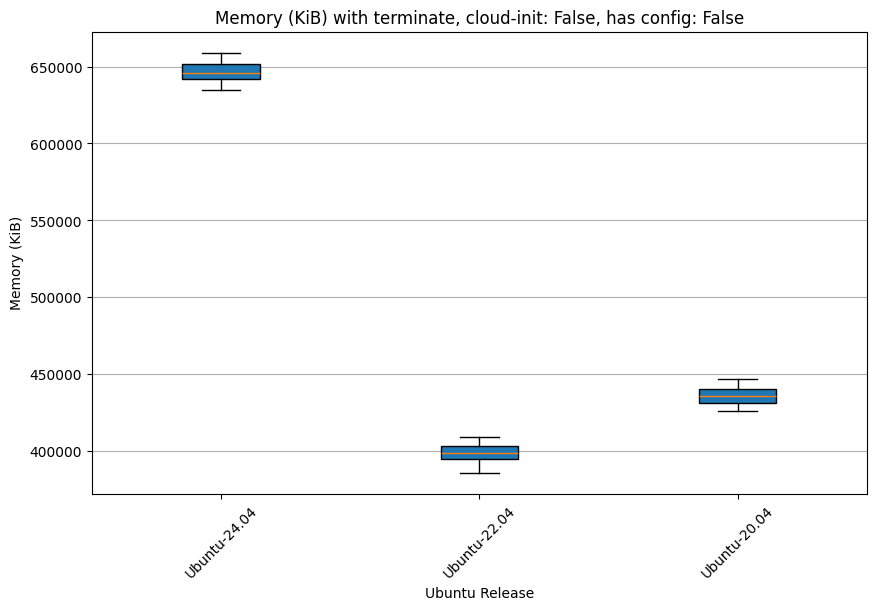

In [6]:
import matplotlib.pyplot as plt


# Function to generate box plots for a specific case
def plot_specific_case(metric, close_method, cloudinit, hasData):
    case_data = []
    labels = []
    for version in ["24.04", "22.04", "20.04"]:
        file_name = (
            f"./non-first-boot/Ubuntu-{version}/{close_method}-cloud-init-{cloudinit}-has-config-{hasData}.txt"
        )
        if file_name in data:
            case_data.append(data[file_name][metric])
            labels.append(f"Ubuntu-{version}")

    if len(labels) == 0:
        print(f"No Data for {close_method}, {metric}, with cloud-init enabled: {cloudinit} and has cloud-config data: {hasData}")
        return
    plt.figure(figsize=(10, 6))
    plt.boxplot(case_data, tick_labels=labels, patch_artist=True)
    plt.title(
        f"{metric} with {close_method}, cloud-init: {cloudinit}, has config: {hasData}"
    )
    plt.ylabel(metric)
    plt.xlabel("Ubuntu Release")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.show()


for close_method in cleanupType:
    for c in [True, False]:
        for d in [True, False]:
            plot_specific_case("Ticks", close_method, c, d)
            plot_specific_case("Memory (KiB)",close_method, c, d)


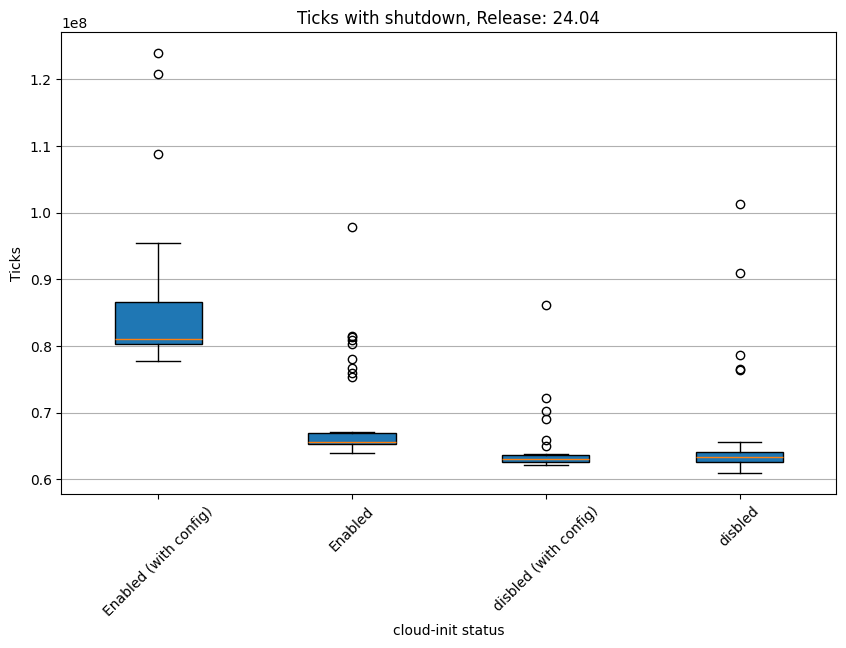

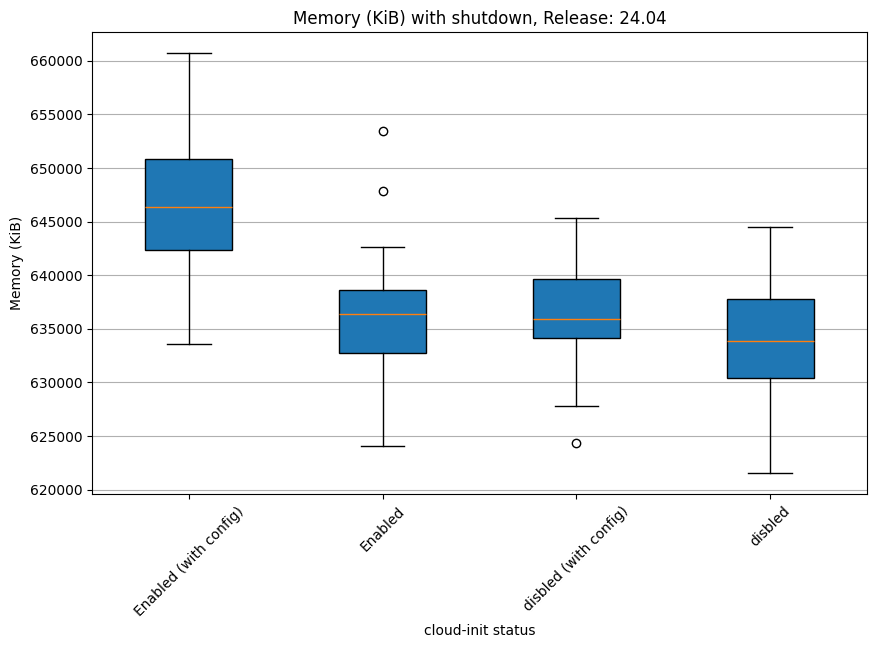

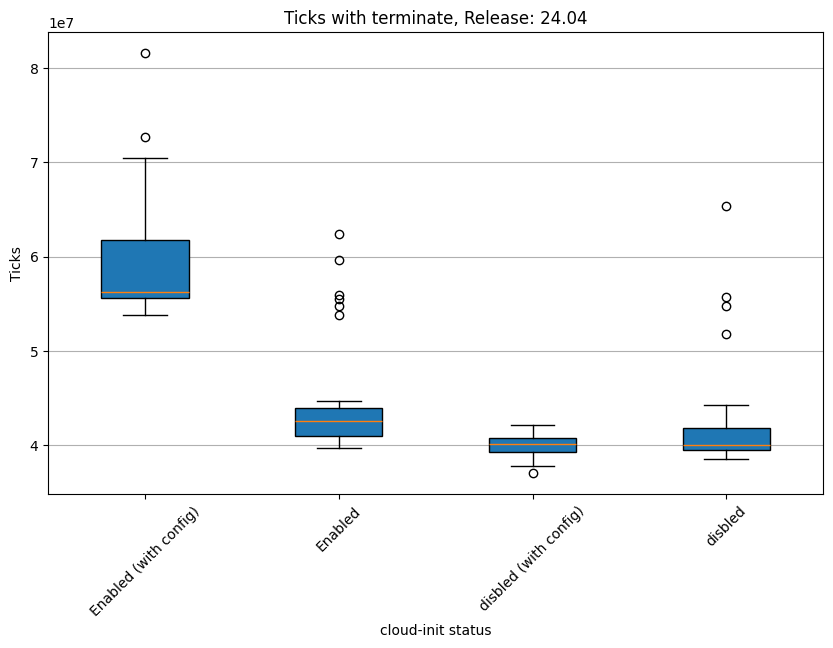

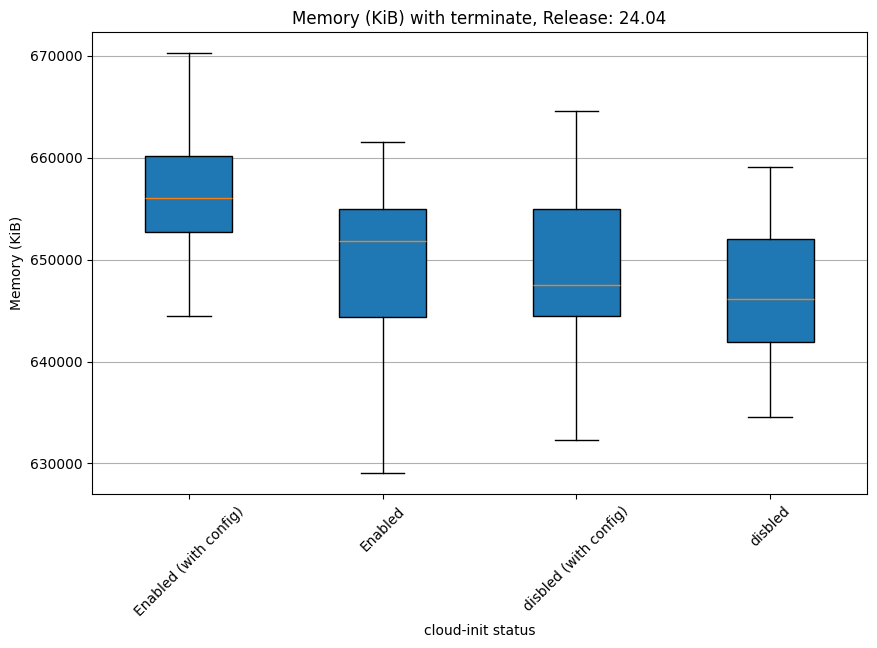

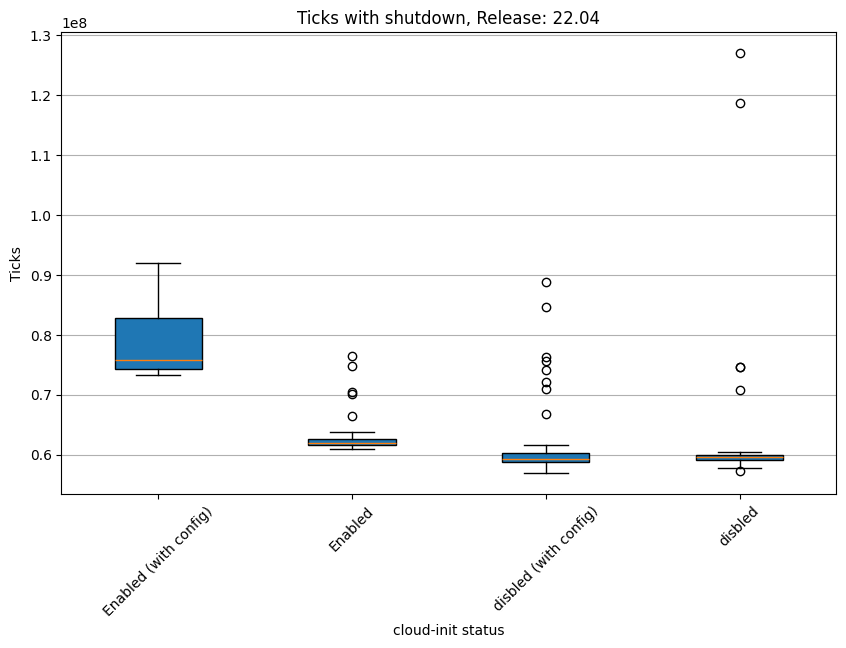

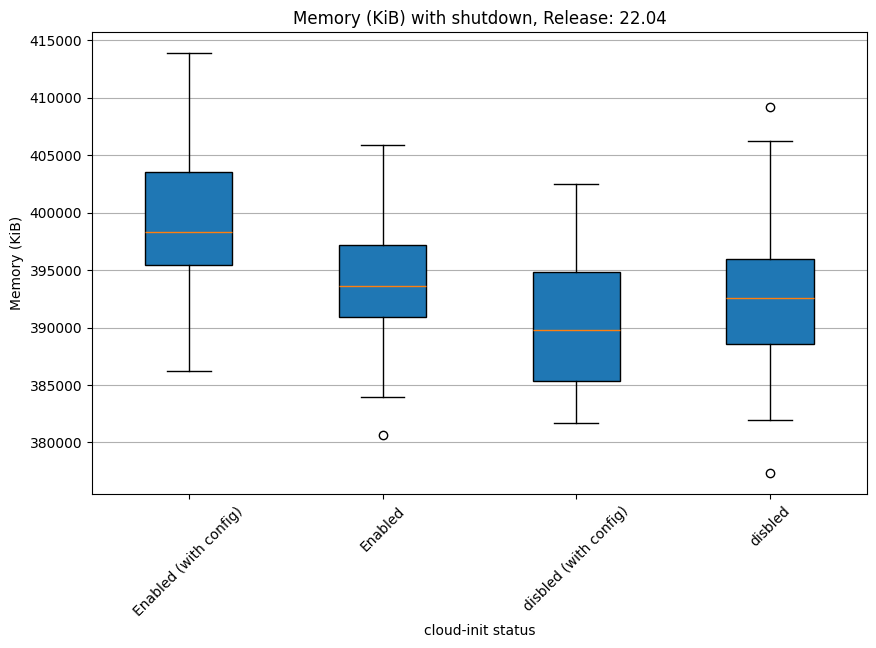

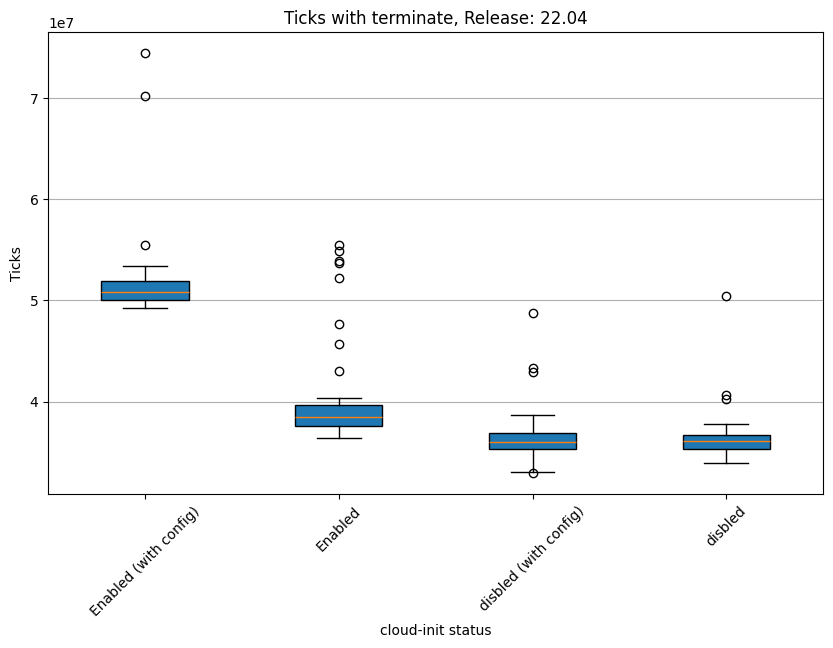

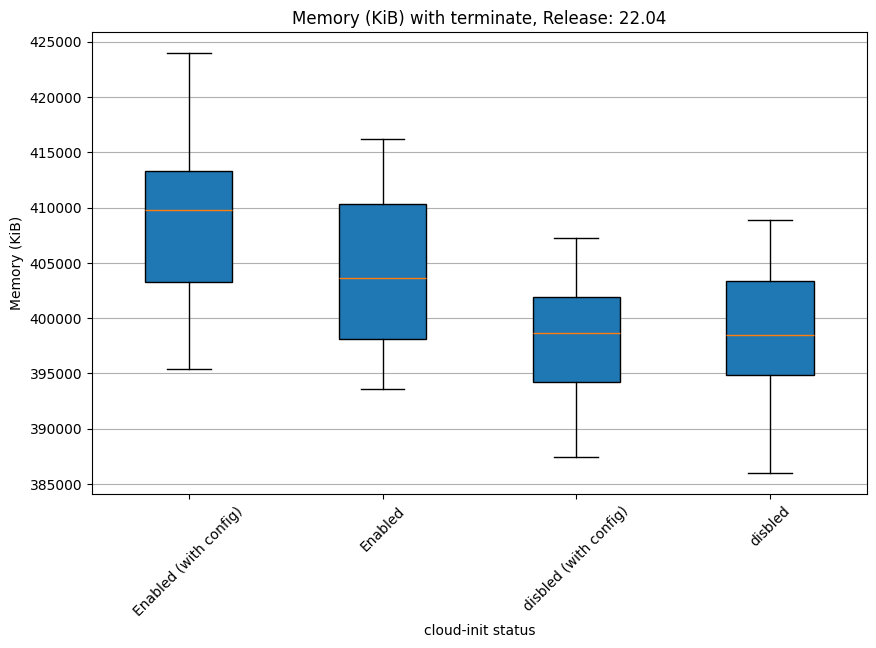

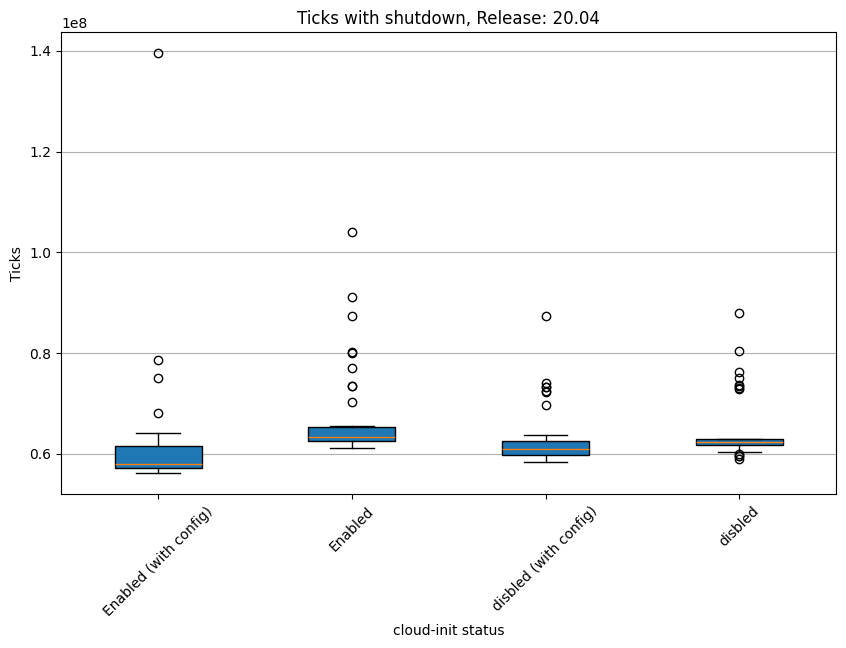

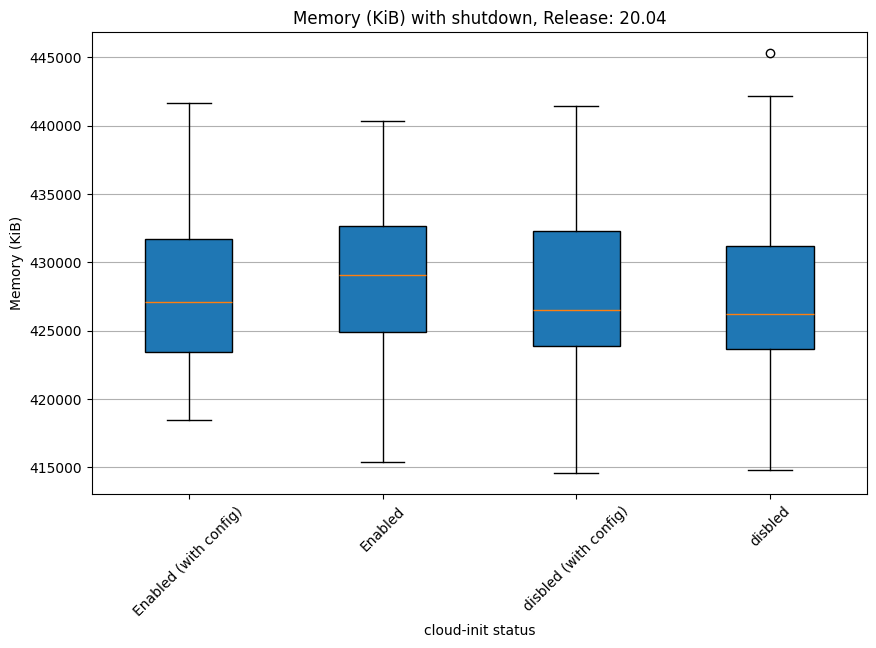

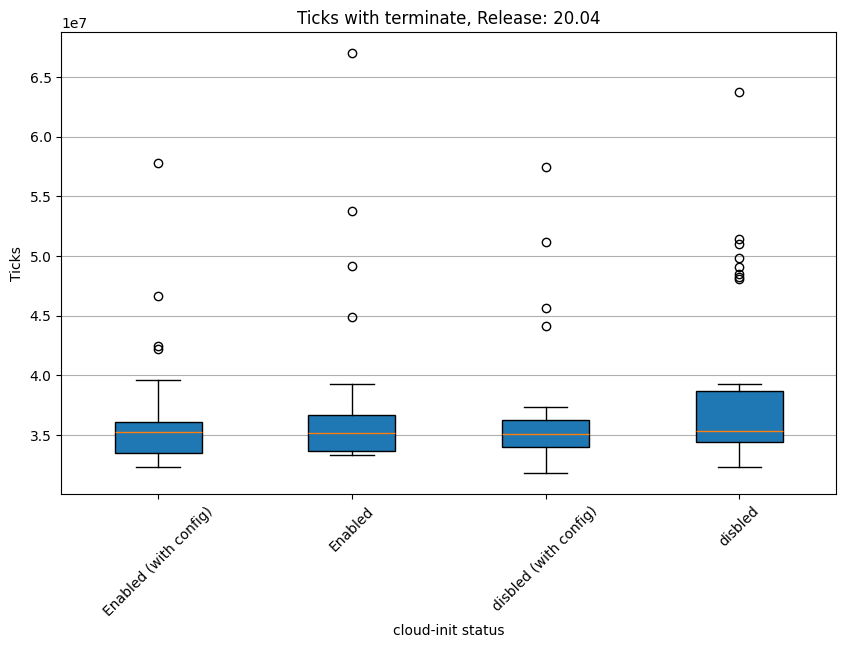

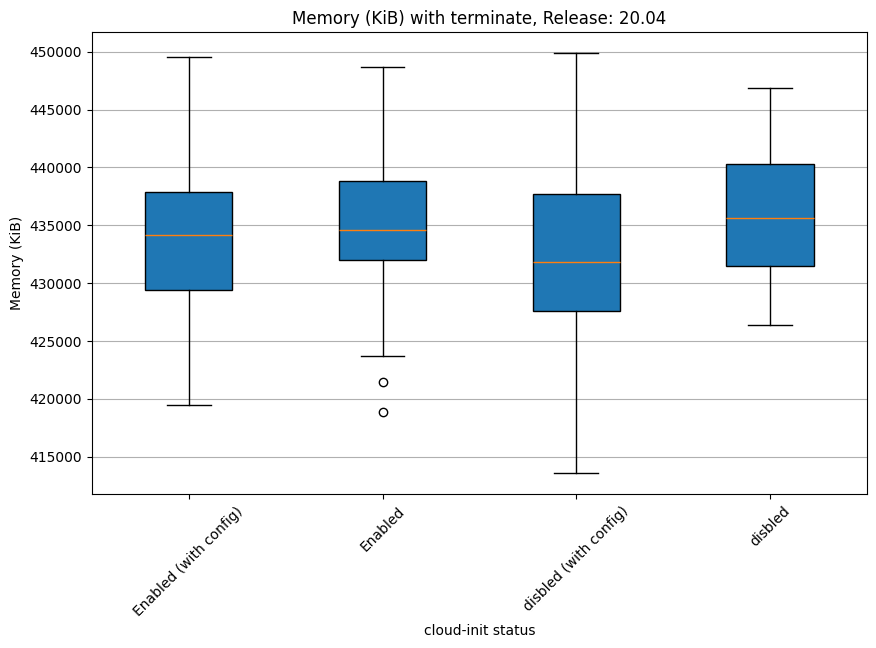

In [7]:
import matplotlib.pyplot as plt


# Function to generate box plots for a specific case
def plot_enable_disable(version, close_method, metric):
    case_data = []
    labels = []
    for ci in [True, False]:
        for d in [True, False]:
            file_name = (
                f"./non-first-boot/Ubuntu-{version}/{close_method}-cloud-init-{ci}-has-config-{d}.txt"
            )
            if file_name in data:
                case_data.append(data[file_name][metric])
                labels.append(("Enabled" if ci else "disbled") + (" (with config)" if d else ""))

    if len(labels) == 0:
        print(f"No Data for {close_method}, {metric}, {version}")
        return
    plt.figure(figsize=(10, 6))
    plt.boxplot(case_data, tick_labels=labels, patch_artist=True)
    plt.title(
        f"{metric} with {close_method}, Release: {version}"
    )
    plt.ylabel(metric)
    plt.xlabel("cloud-init status")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    plt.show()

for version in ["24.04", "22.04", "20.04"]:
    for close_method in cleanupType:
        plot_enable_disable(version, close_method, "Ticks")
        plot_enable_disable(version, close_method, "Memory (KiB)")
